In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime as dt
import urllib.request, json

from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data
from tqdm import tqdm

In [2]:
# importing the dataset

# specify the source from which you want to fetch the stock data
data_source = "alphavantage"

if data_source == "alphavantage":
  # Loading data from alphavantage
  api_key = 'SDRZXYGDDRVQQS3B'

  # specify the ticker to get the price from
  ticker = 'AAL'

  # url containing json file of our ticker
  url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

  # store the data from json file into python dataframe
  with urllib.request.urlopen(url_string) as url:
    data = json.loads(url.read().decode())

    # extract stock market data
    data = data['Time Series (Daily)']
    df = pd.DataFrame(columns=['Date', 'Low', 'High', 'Close', 'Open'])
    for k, v in data.items():
      date = dt.datetime.strptime(k, '%Y-%m-%d')
      data_row = [date.date(),float(v['3. low']),float(v['2. high']),float(v['4. close']),float(v['1. open'])]
      df.loc[-1, :] = data_row
      df.index = df.index + 1

In [3]:
# Sort dataframe by date and print the data
df = df.sort_values('Date')

df.head()


,Date,Low,High,Close,Open
0,2005-09-27,19.1,21.4,19.3,21.05
1,2005-09-28,19.2,20.53,20.5,19.3
2,2005-09-29,20.1,20.58,20.21,20.4
3,2005-09-30,20.18,21.05,21.01,20.26
4,2005-10-03,20.9,21.75,21.5,20.9


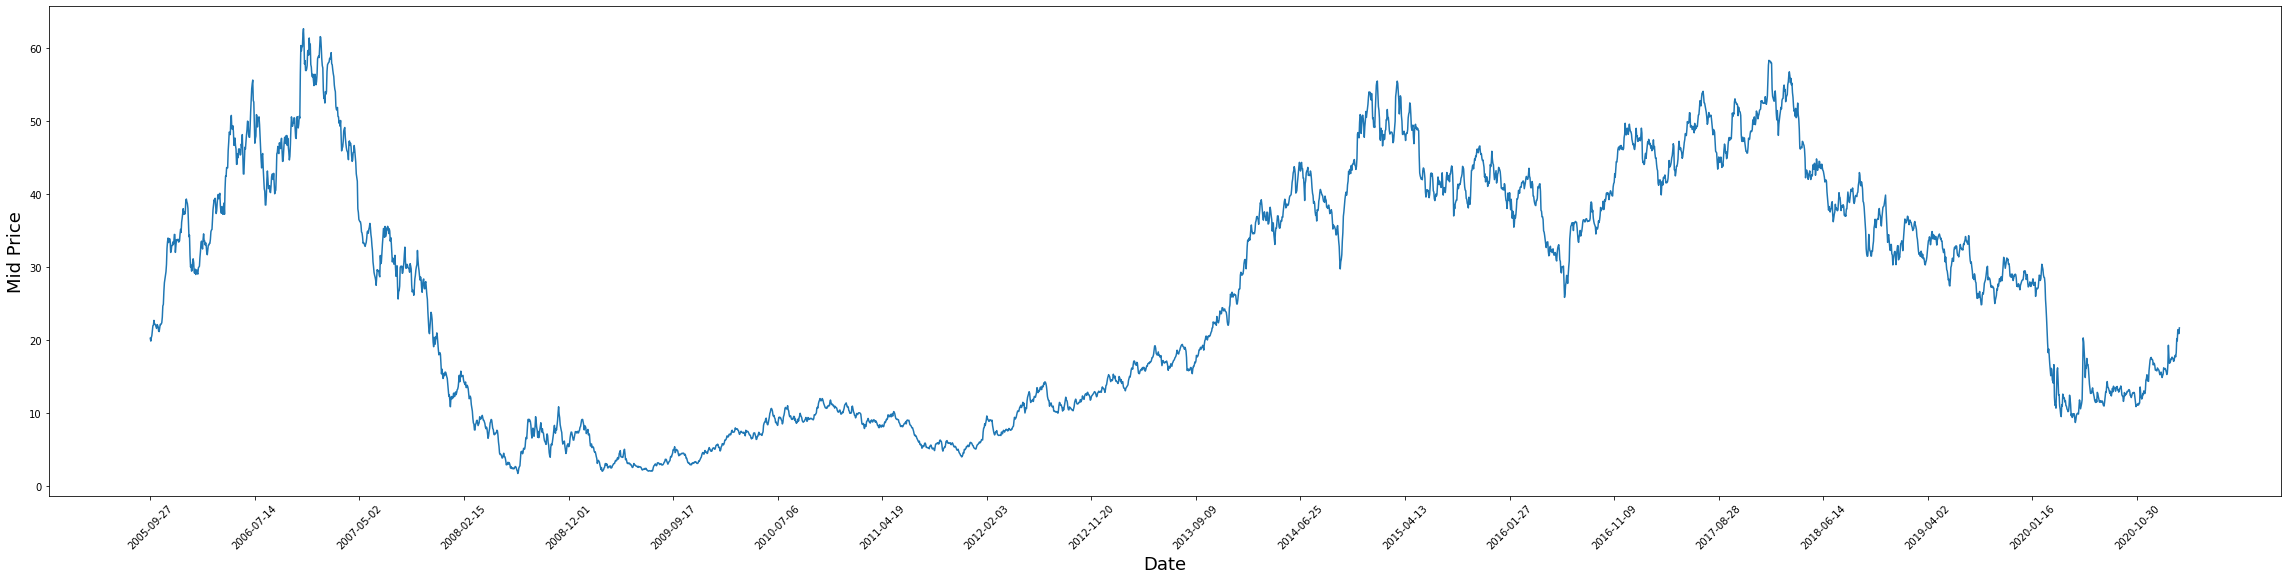

In [4]:
# Data Visualization
plt.figure(figsize=(40, 9))
plt.plot(range(df.shape[0]), (df['Low'] + df['High'])/2.0)
plt.xticks(range(0, df.shape[0], 200), df['Date'].loc[::200], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()

In [5]:
# Splitting mid-price data into training and test set
high_price = df.loc[:,'High'].to_numpy()
low_price = df.loc[:, 'Low'].to_numpy()
mid_price = (high_price + low_price)/2.0

data_train = mid_price[: 2000].reshape(-1, 1)
data_test = mid_price[2000:].reshape(-1, 1)


In [6]:
# Data Normalization: Scale the training data between 0 and 1
scaler = MinMaxScaler()

# fit the training data into minmaxscaler
scaler.fit(data_train)

# scale training and test data to fitted Scaler
data_train = scaler.transform(data_train).reshape(-1)
data_test = scaler.transform(data_test).reshape(-1)

all_mid_data = np.concatenate([data_train, data_test], axis=0)


In [7]:
# smoothing data curve using exponential moving average smoothing
EMA = 0.0
gamma = 0.1
for i in range(len(data_train)):
  EMA = gamma*data_train[i] + (1 - gamma)*EMA
  data_train[i] = EMA

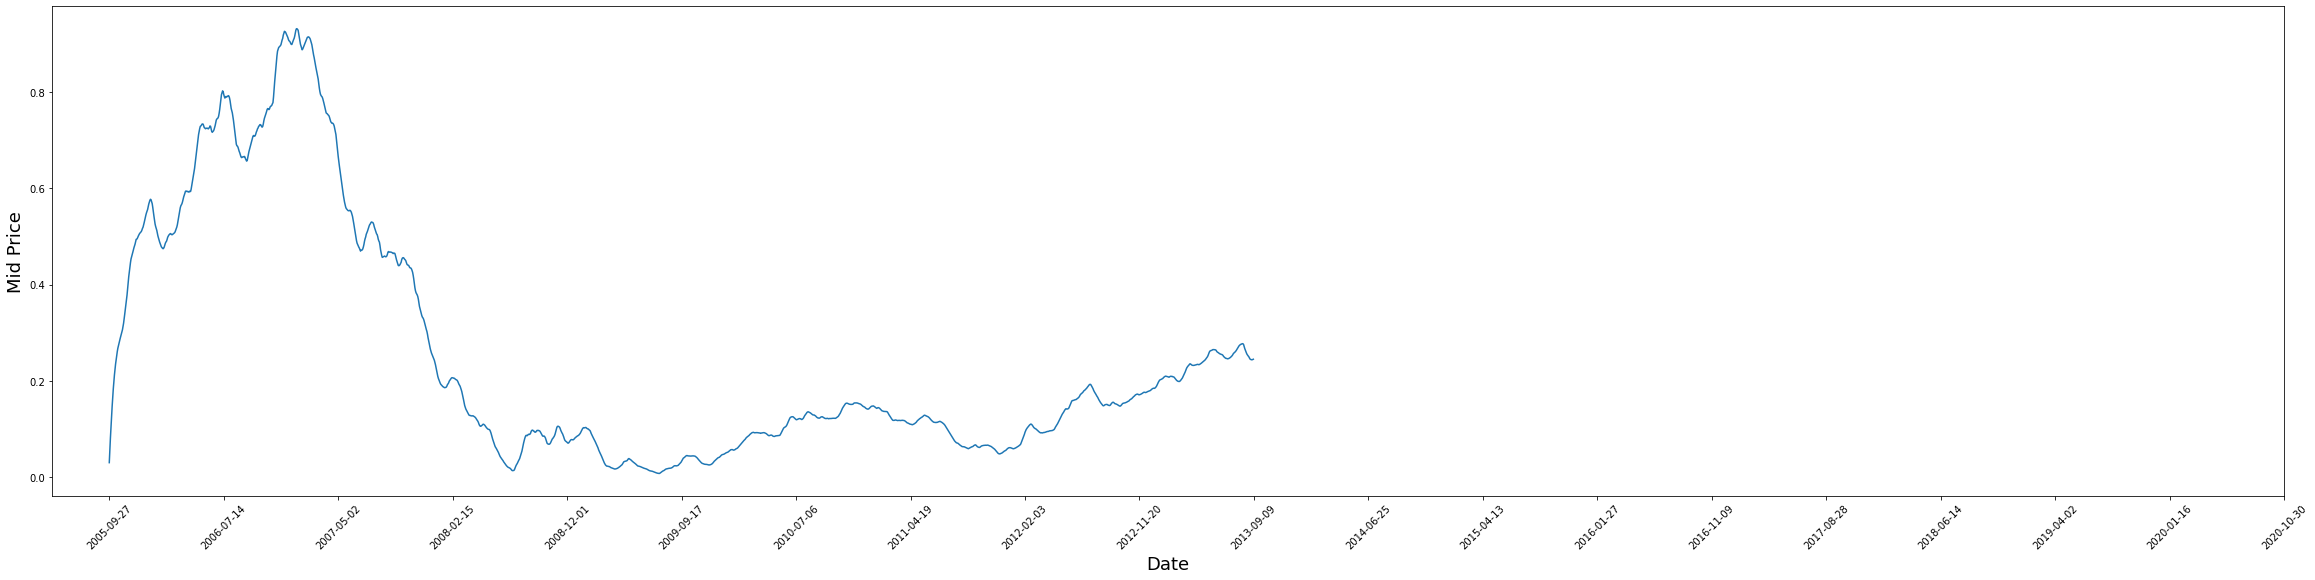

In [8]:
# Data Visualization
plt.figure(figsize=(40, 9))
plt.plot(range(2000), data_train)
plt.xticks(range(0, df.shape[0], 200), df['Date'].loc[::200], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()

### Creating input and ouput for our model 

The first step for training our model is to create a input for our model and output for our model. The input data is a sequence of consecutive stock prices at a certain time period. The output for our model would be the sequence of same length of data except it is shifted to the left by one data. 

For example, if our sequence length is n, then we need to consider break the training data into chunks of sequence of n + 1. The input of our data would be the sequence from index 0 to n, whereas the output data would be the sequence indexing form 1 to n + 1. 




In [9]:
# Create training examples and targets (inputs and outputs batch)

def get_batch(data_train, seq_length, batch_size):
  '''
  data_train: normalized training data, shape = (2000, )
  seq_length: length of consecutive stock data 
  batch_size: a batch of fixed number of sequences, or in other words, no of training examples

  Returns inputs batch and output batch
  '''
  n = len(data_train) - 1   # length of training data
  start_ind = np.random.choice(n - seq_length, batch_size)    # randomly choose the starting index for our sequence.

  # create our input batch and output batch
  input_batch = [data_train[ind : ind + seq_length] for ind in start_ind]
  output_batch = [data_train[ind + 1 : ind + seq_length + 1] for ind in start_ind]

  # reshape our input_batch and ouptut_batch to 3D to match the input for LSTM
  x_batch = np.reshape(input_batch, [batch_size, seq_length, 1])
  y_batch = np.reshape(output_batch, [batch_size, seq_length, 1])

  return x_batch, y_batch


In [10]:
# test to see if the above function correctly outputs the x_batch and y_batch

### RNN Model with LSTM
 
 The RNN Model will have stacked LSTM layers and two dense layers which outputs a single unit. 


In [11]:
# Define our RNN model

def build_model(rnn_units, batch_size, dropout):
  '''
  rnn_units: array consisting of no. of rnn nodes for each layer. the model will have len(rnn_units) LSTM layers
  batch_size: a batch of sequences. the bigger the batch_size, the robust will be our model
  dropout: randomly drop inputs to prevent overfitting of the data

  Returns a RNN model
  '''
  # initiate a sequential model
  model = tf.keras.Sequential()   

  # add stacked LSTM layers
  model.add(tf.keras.layers.LSTM(rnn_units[0], batch_input_shape=[batch_size, None, 1], dropout=dropout, return_sequences=True, recurrent_initializer='glorot_uniform', stateful=True))
  for i in range(len(rnn_units)-1):
      model.add(tf.keras.layers.LSTM(rnn_units[i+1], dropout=dropout, return_sequences=True))

  # add dense layers
  # model.add(tf.keras.layers.Dense(256, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  return model

In [12]:
# visualize the summary of our model by builiding a simple model to test if it's working
model = build_model(rnn_units=[200], batch_size=32, dropout=0.3)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, None, 200)           161600    
_________________________________________________________________
dense (Dense)                (32, None, 1)             201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [13]:
x, y = get_batch(data_train, 15, 2)
print(x)
print('##########')
print(y)
# preds = model(x)
# print(preds)
# print(preds.shape)

[[[0.09368634]
  [0.09634661]
  [0.09887222]
  [0.10112064]
  [0.10246272]
  [0.10312867]
  [0.10261136]
  [0.10308181]
  [0.10339026]
  [0.10335586]
  [0.10199474]
  [0.10112279]
  [0.10049405]
  [0.10034694]
  [0.09899933]]

 [[0.08683777]
  [0.08728446]
  [0.08767007]
  [0.08758193]
  [0.0871167 ]
  [0.08604934]
  [0.08516261]
  [0.08497215]
  [0.08481717]
  [0.08512106]
  [0.08587901]
  [0.08601104]
  [0.0861545 ]
  [0.08637393]
  [0.08661247]]]
##########
[[[0.09634661]
  [0.09887222]
  [0.10112064]
  [0.10246272]
  [0.10312867]
  [0.10261136]
  [0.10308181]
  [0.10339026]
  [0.10335586]
  [0.10199474]
  [0.10112279]
  [0.10049405]
  [0.10034694]
  [0.09899933]
  [0.09804923]]

 [[0.08728446]
  [0.08767007]
  [0.08758193]
  [0.0871167 ]
  [0.08604934]
  [0.08516261]
  [0.08497215]
  [0.08481717]
  [0.08512106]
  [0.08587901]
  [0.08601104]
  [0.0861545 ]
  [0.08637393]
  [0.08661247]
  [0.08662188]]]


### Training the model

To train the model, we will set up different hyperparameters, optimizers and loss function.

In [14]:
# Hyperparameters and Optimization
batch_size = 1
seq_length = 300
learning_rate = 5e-1
num_iterations = 20

# Optimizer
optimizer = tf.keras.optimizers.Adamax()

# model parameters
rnn_units = [400]
dropout = 0.3

#checkpoint location
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


In [15]:
# Train the model 

model = build_model(rnn_units, batch_size, dropout)

def train(x, y):
  with tf.GradientTape() as tape:
    y_pred = model(x)
    loss = tf.keras.losses.mean_squared_error(y, y_pred)
  
  # calculate the gradient w.r.t each trainable variables
  grads = tape.gradient(loss, model.trainable_variables)

  # apply the gradients to our optimzer to update the model
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss


In [16]:
# Begin Training 

# record the  history and plot it in graph
history = []
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_iterations)):

  # feed input into the network
  x_batch, y_batch = get_batch(data_train, seq_length, batch_size)
  loss = train(x_batch, y_batch)

  #update the progress bar
  history.append(loss.numpy().mean())

  # update model with changed weights
  if iter % 100 == 0:
    model.save_weights(checkpoint_prefix)


# save trained model and weights
model.save_weights(checkpoint_prefix)
  

100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


In [17]:
print(history[-1])
print(history)

0.013109933
[0.15929736, 0.111980975, 0.12552729, 0.097990125, 0.07136551, 0.0037059397, 0.01459077, 0.00929395, 0.017788714, 0.44661093, 0.40422538, 0.013744869, 0.004896786, 0.005188961, 0.016107585, 0.04320178, 0.33806306, 0.5153479, 0.0067601902, 0.013109933]


In [23]:
pred = np.squeeze(model.predict(x_batch), axis = 0)
pred = scaler.inverse_transform(pred)
print(pred.shape)
x = scaler.inverse_transform(np.squeeze(x_batch, axis=0))
print(x)
print(pred)

(300, 1)
[[ 7.27461983]
 [ 7.15015784]
 [ 7.05164206]
 [ 6.91897785]
 [ 6.79558007]
 [ 6.69002206]
 [ 6.57401986]
 [ 6.43611787]
 [ 6.33800608]
 [ 6.25820547]
 [ 6.17288493]
 [ 6.10909643]
 [ 6.08268679]
 [ 6.06591811]
 [ 6.0353263 ]
 [ 5.96529367]
 [ 5.9032643 ]
 [ 5.83893787]
 [ 5.78104409]
 [ 5.73243968]
 [ 5.68119571]
 [ 5.62607614]
 [ 5.61146852]
 [ 5.60182167]
 [ 5.60513951]
 [ 5.59012555]
 [ 5.554113  ]
 [ 5.5077017 ]
 [ 5.47493153]
 [ 5.44793838]
 [ 5.41264454]
 [ 5.35888008]
 [ 5.35349208]
 [ 5.39014287]
 [ 5.43212858]
 [ 5.47441572]
 [ 5.50797415]
 [ 5.55167674]
 [ 5.59100906]
 [ 5.60840816]
 [ 5.64056734]
 [ 5.70451061]
 [ 5.76555955]
 [ 5.80400359]
 [ 5.83710323]
 [ 5.82589291]
 [ 5.74930362]
 [ 5.65437326]
 [ 5.59793593]
 [ 5.56014234]
 [ 5.5376281 ]
 [ 5.51486529]
 [ 5.52387876]
 [ 5.58449089]
 [ 5.6400418 ]
 [ 5.70003762]
 [ 5.72253386]
 [ 5.74878047]
 [ 5.76240242]
 [ 5.77216218]
 [ 5.78694596]
 [ 5.80375137]
 [ 5.79637623]
 [ 5.78523861]
 [ 5.79171475]
 [ 5.80654327]
 

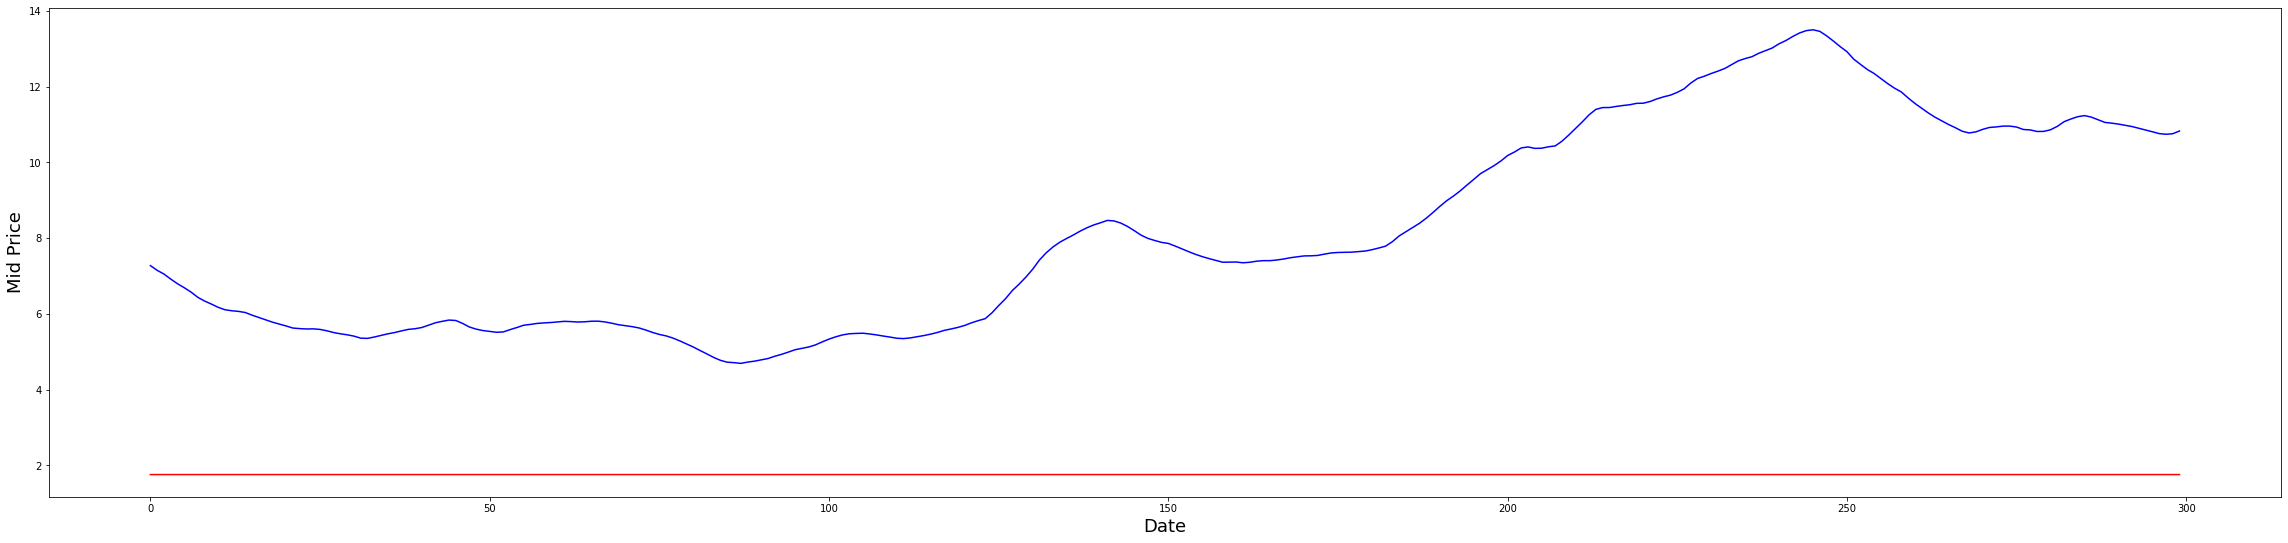

In [25]:
plt.figure(figsize=(40, 9))
plt.plot(range(300), x.flatten(), color='blue')
plt.plot(range(300), pred.flatten(), color='red')
#plt.xticks(range(0, df.shape[0], 200), df['Date'].loc[::200], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Mid Price', fontsize=18)
plt.show()